Code source: Tutorial by Giorgio Domenichini

CPHF: CPHF (Coupled Perturbed Hartree-Fock) alchemical derivatives are quantities used in computational chemistry and quantum chemistry to calculate the change in molecular properties with respect to changes in the nuclear positions or atomic charges.

Gaussian-type orbitals (GTOs) are mathematical functions commonly used to represent atomic orbitals in quantum chemistry calculations. They are named after the Gaussian distribution function that describes their radial behavior. GTOs provide a flexible and efficient basis for approximating the wavefunctions of electrons in molecules.

Basis sets are a set of mathematical functions that are used to approximate the wave functions of electrons in molecules

In [1]:
import sys
sys.path.append('../APDFT')
sys.path.append('../Data')

In [2]:
from pyscf import gto,scf
import numpy as np
import pandas as pd
import pyscf
import matplotlib.pyplot as plt
import basis_set_exchange as bse
from FcMole import FcM, FcM_like
import os
import ast
from IPython.display import display

%load_ext autoreload
%autoreload 2
from AP_class import APDFT_perturbator as AP

In [3]:
# mol_NN = gto.M(atom= "N 0 0 0; N 0 0 2.1",
#                unit="Bohr",
#                basis="unc-cc-pvdz")

In [4]:
# mf = scf.RKS(mol_NN) # create a restricted Kohn-Sham (RKS) mean-field object used for electronic structure calculation
# mf.xc = "PBE0" # sets the exchange-correlation (XC) functional to "PBE0"
# energy = mf.scf()

In [5]:
# ap_nn=AP(mf,sites=[0,1]) # prepare to perform alchemical perturbing DFT calculations
# H = ap_nn.build_hessian()
# print(H)

## Calculating Hessian ##

In [6]:
# create the NN molecule
mol_NN_pcX2=gto.M(atom= "N 0 0 0; N 0 0 2.1",
                  unit="Bohr",
                  basis=bse.get_basis('pcX-2',fmt="nwchem",elements=[6,7,8]))

# the unit corresponds the length unit used when specifying atomic positions
# the pcX-2 basis set is a specialized basis set for systems containing C, N, and O

In [7]:
def get_energy_DFT(mol):
    """ 
    Compute the total energy of a given molecule, in a.u., using DFT calculation

    Args:
        mol (pyscf.gto.mole.Mole): a PySCF Gaussian-type orbital (GTO) molecule object 
    
    Returns:
        mf (pyscf.dft.rks.RKS): the mean-field object for the molecule (used for other DFT related calculations) 
        energy (float): the total energy of the molecule
    """

    mf = scf.RKS(mol) # create a restricted Kohn-Sham (RKS) mean-field object used for electronic structure calculation
    mf.xc = "PBE0" # sets the exchange-correlation (XC) functional to "PBE0"
    energy = mf.scf() # performs self-consistent field (SCF) calculations

    return energy, mf

In [8]:
def get_energy_HF(mol):
    """ 
    Compute the total energy of a given molecule, in a.u., using DFT calculation

    Args:
        mol (pyscf.gto.mole.Mole): a PySCF Gaussian-type orbital (GTO) molecule object 
    
    Returns:
        mf (pyscf.dft.rks.RKS): the mean-field object for the molecule (used for other DFT related calculations) 
        energy (float): the total energy of the molecule
    """

    mf = scf.RHF(mol) # create a restricted Hartree-Fock (RHF) mean-field object used for electronic structure calculation
    energy = mf.scf() # performs self-consistent field (SCF) calculations

    return energy, mf

In [9]:
# Calculate the energy and the Hessian

energy_nn, mf_nn = get_energy_DFT(mol_NN_pcX2)
ap_nn=AP(mf_nn,sites=[0,1]) # prepare to perform alchemical perturbing DFT calculations
H = ap_nn.build_hessian()
print(H)

converged SCF energy = -109.444276410408
[[-3.30695508  0.47774726]
 [ 0.47774726 -3.30695508]]


In [10]:
# compute the diagnalization matrix (of eigenvectors) Q

epsilon, Q = np.linalg.eig(H)
Q_inv = np.linalg.inv(Q)
print(Q_inv)

[[-0.70710678  0.70710678]
 [-0.70710678 -0.70710678]]


## Import Training Data ##

In [11]:
def get_diatomic_data(ap_mol):
    """ 
    Get the diatomic molecule data and store them in pandas dataframe
    If there exist a file with pre-calculated diatomic energy, directly open it.
    If not, calculate the energy for each molecule and store the data as a separate file

    Args:
        ap_mol (APDFT_perturbator): the reference molecule (used for APDFT calculations)
    
    Returns:
        diatomic_data (pandas dataframe): dataframe containing the perturbation vector and the energy of each molecule
    """
    
    if os.path.isfile('../Data/diatomic_data_w_energy.csv'):
        diatomic_data = pd.read_csv('../Data/diatomic_data_w_energy.csv', header = 0)
        diatomic_data['dx'] = diatomic_data['dx'].apply(lambda x: ast.literal_eval(x))
    
    elif os.path.isfile('../Data/diatomic_data.csv'):
        diatomic_data = pd.read_csv('diatomic_data.csv', header = 0)
        
        # creating the dx column and calculate the total energy of each molecule
        diatomic_data['dx'] = None
        diatomic_data['energy'] = None

        for index, row in diatomic_data.iterrows():
            dx = [row['charge_1'] - 7, row['charge_2'] - 7] # calculates the dx vector from the charge of each atom
            
            # target_mol = FcM_like(mol, fcs=dx) # build target molecule from specified perturbation
            target_energy = ap_mol.target_energy(dx)

            diatomic_data.at[index, 'dx'] = dx
            diatomic_data.at[index, 'energy'] = target_energy
            diatomic_data.to_csv('../Data/diatomic_data_w_energy.csv')
    
    return diatomic_data

In [12]:
diatomic_data = get_diatomic_data(ap_nn)
display(diatomic_data)
# print(diatomic_data['dx'].dtype)

,Unnamed: 0,Name,charge_1,charge_2,dx,energy
0,0,N2,7,7,"[0, 0]",-108.982443
1,1,NO +,7,8,"[0, 1]",-128.950506
2,2,CN -,6,7,"[-1, 0]",-92.335593
3,3,NC -,7,6,"[0, -1]",-92.335593
4,4,ON +,8,7,"[1, 0]",-128.950506
5,5,O2 2+,8,8,"[1, 1]",-148.301451
6,6,NF 2+,7,9,"[0, 2]",-152.508900
7,7,CO,6,8,"[-1, 1]",-112.786392
8,8,BN 2-,5,7,"[-2, 0]",-78.809317
9,9,C2 2-,6,6,"[-1, -1]",-75.324778


In [13]:
# creating the dx column and calculate the total energy of each molecule

# diatomic_data['dx'] = None
# diatomic_data['energy'] = None

# for index, row in diatomic_data.iterrows():
#     dx = [row['charge_1'] - 7, row['charge_2'] - 7] # calculates the dx vector from the charge of each atom
#     energy = ap_nn.target_energy(dx) # calculates the energy of the molecule
#     diatomic_data.at[index, 'dx'] = dx
#     diatomic_data.at[index, 'energy'] = energy
# print(diatomic_data)

In [14]:
# diatomic_data.to_csv('diatomic_data_w_energy.csv', index=False)

In [15]:
# express each molecule using the ANM basis
# i.e. c = Q_inv @ dx

dx_array = np.array(diatomic_data['dx'].tolist())
# print(dx_array)

c_array = (Q_inv @ dx_array.T).T
# print(c_array)

# print(c_array.tolist())

diatomic_data['c'] = c_array.tolist()
diatomic_data['coord_0'] = diatomic_data['c'].apply(lambda x: x[0])
diatomic_data['coord_1'] = diatomic_data['c'].apply(lambda x: x[1])

display(diatomic_data)

,Unnamed: 0,Name,charge_1,charge_2,dx,energy,c,coord_0,coord_1
0,0,N2,7,7,"[0, 0]",-108.982443,"[0.0, 0.0]",0.000000e+00,0.000000e+00
1,1,NO +,7,8,"[0, 1]",-128.950506,"[0.7071067811695315, -0.7071067812035634]",7.071068e-01,-7.071068e-01
2,2,CN -,6,7,"[-1, 0]",-92.335593,"[0.7071067812035634, 0.7071067811695315]",7.071068e-01,7.071068e-01
3,3,NC -,7,6,"[0, -1]",-92.335593,"[-0.7071067811695315, 0.7071067812035634]",-7.071068e-01,7.071068e-01
4,4,ON +,8,7,"[1, 0]",-128.950506,"[-0.7071067812035634, -0.7071067811695315]",-7.071068e-01,-7.071068e-01
5,5,O2 2+,8,8,"[1, 1]",-148.301451,"[-3.403188841843985e-11, -1.414213562373095]",-3.403189e-11,-1.414214e+00
6,6,NF 2+,7,9,"[0, 2]",-152.508900,"[1.414213562339063, -1.4142135624071268]",1.414214e+00,-1.414214e+00
7,7,CO,6,8,"[-1, 1]",-112.786392,"[1.414213562373095, -3.403188841843985e-11]",1.414214e+00,-3.403189e-11
8,8,BN 2-,5,7,"[-2, 0]",-78.809317,"[1.4142135624071268, 1.414213562339063]",1.414214e+00,1.414214e+00
9,9,C2 2-,6,6,"[-1, -1]",-75.324778,"[3.403188841843985e-11, 1.414213562373095]",3.403189e-11,1.414214e+00


## Regression ##

In [41]:
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import warnings

In [17]:
X = diatomic_data[['coord_0', 'coord_1']]
y = diatomic_data['energy']

### Gaussian Kernel ###

In [18]:
# Gaussian kernel

gaussian_KRR = KernelRidge(kernel='rbf', gamma=0.05, alpha = 0.05)

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = cross_val_score(gaussian_KRR, X, y, scoring='neg_mean_squared_error', cv=k_fold)
mse_scores = -mse_scores  # Convert negative MSE scores to positive

# Calculate the average error across all folds
avg_mse = mse_scores.mean()

# Print the mean squared error for each fold
for fold, mse in enumerate(mse_scores):
    print(f"Fold {fold+1}: MSE = {mse}")

# Print the average mean squared error
print(f"Average MSE across all folds: {avg_mse}")

Fold 1: MSE = 35.43271127259999
Fold 2: MSE = 16.070377138394253
Fold 3: MSE = 37.0765619783568
Fold 4: MSE = 81.23406968636051
Fold 5: MSE = 85.44062013399846
Average MSE across all folds: 51.050868041942


### Polynomial Kernel ###

In [19]:
# Polynomial Kernel

poly_KRR = KernelRidge(kernel='polynomial', degree=3, alpha = 0.01)

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = cross_val_score(poly_KRR, X, y, scoring='neg_mean_squared_error', cv=k_fold)
mse_scores = -mse_scores  # Convert negative MSE scores to positive

# Calculate the average error across all folds
avg_mse = mse_scores.mean()

# Print the mean squared error for each fold
for fold, mse in enumerate(mse_scores):
    print(f"Fold {fold+1}: MSE = {mse}")

# Print the average mean squared error
print(f"Average MSE across all folds: {avg_mse}")

Fold 1: MSE = 0.14559210190989566
Fold 2: MSE = 0.06559608057628473
Fold 3: MSE = 0.038410377354155416
Fold 4: MSE = 0.03779716545969974
Fold 5: MSE = 0.0757750984360615
Average MSE across all folds: 0.07263416474721941


### Ridge Regression ###

In [42]:
ridge_regression = Ridge(alpha=0.01)

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = cross_val_score(ridge_regression, X, y, scoring='neg_mean_squared_error', cv=k_fold)
mse_scores = -mse_scores  # Convert negative MSE scores to positive

# Calculate the average error across all folds
avg_mse = mse_scores.mean()

# Print the mean squared error for each fold
for fold, mse in enumerate(mse_scores):
    print(f"Fold {fold+1}: MSE = {mse}")

# Print the average mean squared error
print(f"Average MSE across all folds: {avg_mse}")

Fold 1: MSE = 15.04674196935539
Fold 2: MSE = 9.967973137302312
Fold 3: MSE = 8.027714240739568
Fold 4: MSE = 6.047457005582891
Fold 5: MSE = 15.087792712480383
Average MSE across all folds: 10.835535813092111


## Hyperparameter Tuning ##

### Gaussian Kernel ###

In [20]:
# # Grid Search Round 1

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-5), np.log10(100), num=20),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.logspace(np.log10(1e-5), np.log10(100), num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 1e-05, 'gamma': 0.02069138081114788, 'kernel': 'rbf'}
Best Mean Squared Error: 0.0629779294268316


In [21]:
# # Grid Search Round 2

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-7), np.log10(1e-5), num=20),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.logspace(np.log10(0.001), np.log10(0.1), num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 1e-07, 'gamma': 0.004281332398719396, 'kernel': 'rbf'}
Best Mean Squared Error: 0.002398338809599357


In [22]:
# # Grid Search Round 3

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-9), np.log10(1e-7), num=20),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.linspace(0.003, 0.005, num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 1e-09, 'gamma': 0.005, 'kernel': 'rbf'}
Best Mean Squared Error: 0.0006313352826684056


In [23]:
# # Grid Search Round 4

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-11), np.log10(1e-9), num=20),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.linspace(0.003, 0.005, num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 2.6366508987303556e-11, 'gamma': 0.005, 'kernel': 'rbf'}
Best Mean Squared Error: 6.867484634063021e-05


In [25]:
# # Grid Search Round 5

# param_grid = {
#     'alpha': np.linspace(2e-11, 3e-11, num=21),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.linspace(0.003, 0.005, num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 2.45e-11, 'gamma': 0.005, 'kernel': 'rbf'}
Best Mean Squared Error: 6.856264616111249e-05


### Polynomial Kernel ###

In [29]:
# # Hyperparam tuning
# # Grid search round 1

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-5), np.log10(100), num=50),
#     'kernel': ['poly'],  
#     'degree': [1, 2, 3, 4], 
#     'coef0': np.logspace(np.log10(1e-5), np.log10(100), num=50), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 1.9306977288832496e-05, 'coef0': 71.96856730011514, 'degree': 4, 'kernel': 'poly'}
Best Mean Squared Error: 0.0003993977280248376


In [30]:
# # Hyperparam tuning
# # Grid search round 2

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-6), np.log10(1e-4), num=30),
#     'kernel': ['poly'],  
#     'degree': [2, 3, 4], 
#     'coef0': np.linspace(50, 100, num=51), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 1e-06, 'coef0': 100.0, 'degree': 4, 'kernel': 'poly'}
Best Mean Squared Error: 0.00039639327274242824


In [33]:
# # Hyperparam tuning
# # Grid search round 3

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-8), np.log10(1e-6), num=20),
#     'kernel': ['poly'],  
#     'degree': [4], 
#     'coef0': np.linspace(100, 200, num=51), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
#     grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 1.438449888287663e-07, 'coef0': 188.0, 'degree': 4, 'kernel': 'poly'}
Best Mean Squared Error: 0.00021398051735017613


In [35]:
# # Hyperparam tuning
# # Grid search round 4

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-7), np.log10(1e-6), num=20),
#     'kernel': ['poly'],  
#     'degree': [4], 
#     'coef0': np.linspace(170, 200, num=31), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
#     grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 1.2742749857031348e-07, 'coef0': 188.0, 'degree': 4, 'kernel': 'poly'}
Best Mean Squared Error: 0.00021398051735017613


### Ridge Regression ###

In [46]:
# # Grid Search
# # Round 1

# ridge_model = Ridge()

# # Define the hyperparameters to tune and their respective values
# param_grid = {
#     'alpha': np.logspace(np.log10(0.0001), np.log10(1000), num=80),  # Regularization strength
#     'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],  # Solver algorithm
# }

# # Perform grid search using cross-validation
# grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X, y)

# # Retrieve the best hyperparameters and the corresponding mean squared error
# best_params = grid_search.best_params_
# best_mse = -grid_search.best_score_

# # Print the best hyperparameters and the corresponding mean squared error
# print("Best Hyperparameters:")
# print(best_params)
# print("Best Mean Squared Error:", best_mse)

Best Hyperparameters:
{'alpha': 0.12626001098748565, 'solver': 'svd'}
Best Mean Squared Error: 20.23556020612791


## Learning Curve ##

In [27]:
def evaluate_performance(model, X, y, num_training_sample, num_trials):

    """ 
    Given the number of training samples used, 
    calculate the average and standard deviation of MSE across a certain number of trials.
    For each trial, a specified number of training examples is used to train the model, 
    which is then evaluated on the rest of the data set.

    Args:
        X (ndarray): training data; size (N, m) where N is the number of training examples and m is the number of features
        y (ndarray): target data; size (N, 1)
        num_training_sample (int): the number of samples used for training
        num_trials: the number of trials 
    
    Returns:
        average_error: the average MSE across all trials
        std_dev_error: standard deviation of the error across all trials
    """

    errors = []
    test_size = 1.0 - num_training_sample/X.shape[0]

    for i in range(num_trials):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        error = np.sqrt(mean_squared_error(y_val, y_pred)) # Root mean squared error
        errors.append(error)
    
    average_error = np.mean(errors)
    std_dev_error = np.std(errors)
    return average_error, std_dev_error

### Gaussian Kernel ###

In [28]:
# Gaussian Kernel

best_params_gaussian_KRR = {'alpha': 2.45e-11, 'gamma': 0.005, 'kernel': 'rbf'}
gaussian_KRR_model = KernelRidge(**best_params_gaussian_KRR)

columns = ['training size', 'average RMSE', 'standard deviation']
model_performance_gaussian_KRR = pd.DataFrame(columns=columns)

training_size = [i for i in range(1, 21)]
num_trials = 20

for num_training_sample in training_size:
    index = num_training_sample - 1
    average_error, std_dev_error = evaluate_performance(gaussian_KRR_model, X, y, num_training_sample, num_trials)
    model_performance_gaussian_KRR.at[index, 'training size'] = num_training_sample
    model_performance_gaussian_KRR.at[index, 'average RMSE'] = average_error
    model_performance_gaussian_KRR.at[index, 'standard deviation'] = std_dev_error

display(model_performance_gaussian_KRR)

,training size,average RMSE,standard deviation
0,1,45.735661,8.66906
1,2,33.299112,15.419637
2,3,10.09422,4.994681
3,4,6.16641,1.947065
4,5,4.483423,2.075281
5,6,1.201561,0.635291
6,7,1.201561,0.635291
7,8,0.64464,0.313215
8,9,0.434282,0.2311
9,10,0.259472,0.184565


### Polynomial Kernel ###

In [38]:
best_params_poly_KRR = {'alpha': 1.2742749857031348e-07, 'coef0': 188.0, 'degree': 4, 'kernel': 'poly'}
poly_KRR_model = KernelRidge(**best_params_poly_KRR)

columns = ['training size', 'average RMSE', 'standard deviation']
model_performance_poly_KRR = pd.DataFrame(columns=columns)

training_size = [i for i in range(1, 21)]
num_trials = 20

with warnings.catch_warnings():
    for num_training_sample in training_size:
        warnings.filterwarnings("ignore")
        index = num_training_sample - 1
        average_error, std_dev_error = evaluate_performance(poly_KRR_model, X, y, num_training_sample, num_trials)
        model_performance_poly_KRR.at[index, 'training size'] = num_training_sample
        model_performance_poly_KRR.at[index, 'average RMSE'] = average_error
        model_performance_poly_KRR.at[index, 'standard deviation'] = std_dev_error

display(model_performance_poly_KRR)

,training size,average RMSE,standard deviation
0,1,45.742738,8.855386
1,2,32.979548,15.927009
2,3,7.789003,3.930757
3,4,4.693477,1.514323
4,5,3.361452,1.644637
5,6,0.583746,0.372481
6,7,0.583746,0.372481
7,8,0.283254,0.181353
8,9,0.182454,0.145612
9,10,0.110874,0.082991


In [ ]:
# # graphing

# graph_x = model_performance['training size']
# graph_y = model_performance['average RMSE']
# graph_error = model_performance['standard deviation']

# # Set figure size
# plt.figure(figsize=(10, 6))

# # Create line plot with error bars
# plt.errorbar(graph_x, graph_y, yerr=graph_error, marker='o', linestyle='-', capsize=4)

# # Set axis labels and title
# plt.xlabel('Training Size')
# plt.ylabel('Average RMSE')
# plt.title('Learning curve for diatomic molecule energy prediction using polynomial KNN')

# plt.xscale('log')
# plt.yscale('log')


# # Save the figure as a PNG image
# plt.savefig('learning_curve_20_points.png', dpi=300)
# plt.show()

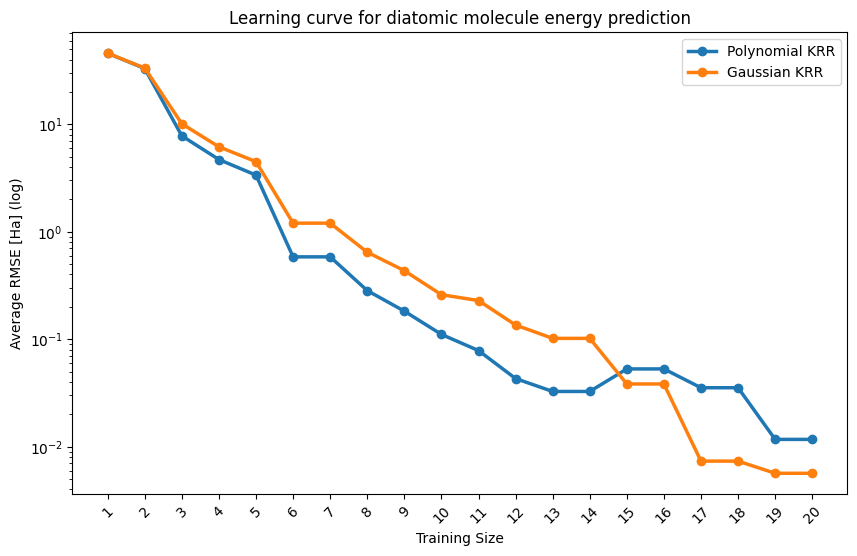

In [53]:
# Set figure size
plt.figure(figsize=(10, 6))

# Load the data
x = model_performance_poly_KRR['training size']
y1 = model_performance_poly_KRR['average RMSE']
y2 = model_performance_gaussian_KRR['average RMSE']

# Plotting
plt.plot(x, y1, label='Polynomial KRR', marker='o', linestyle='-', linewidth=2.5)
plt.plot(x, y2, label='Gaussian KRR', marker='o', linestyle='-', linewidth=2.5)

# Customize the x label
plt.xticks(range(1, 21), rotation=45, ha='center') 
plt.gca().xaxis.set_tick_params(which='both', labelbottom=True)

# Customize the plot
plt.title('Learning curve for diatomic molecule energy prediction')
plt.xlabel('Training Size')
plt.ylabel('Average RMSE [Ha] (log)')
plt.legend()

# Create log scale
plt.xscale('log')
plt.yscale('log')

# Display the plot
plt.savefig('../Graph/[Diatomic] learning_curve_log_log.png', dpi=300)
plt.show()